# Using various models for elastic moduli prediction

In this notebook, performances of different ML algorithms used to predict elastic moduli are evaluated. Performance of the models are also evaluated while changing the size of training set.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymatgen as pmg
import time
import matplotlib.pyplot as plt

from matminer.utils.conversions import str_to_composition
from matminer.featurizers import composition as cf
from matminer.featurizers import structure as struc
from matminer.featurizers.base import MultipleFeaturizer

from pymatgen import MPRester

from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_predict, ShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

Load featurized data

In [2]:
data = pd.read_pickle('./dejong_featurized_data.pkl')
print ("Shape of data:", data.shape)

Shape of data: (1181, 107)


## Part 1: Specifying input data

Here, several different data sizes are specified so that we can quantify performance of some machine learning algorithms with respect to the data input size. 

In [3]:
sizes = [10, 50, 100, 500, 1000]

In [4]:
num_splits=5

We impute X and assign log of K_VRH/G_VRH to y

In [5]:
x = data.drop(['material_id', 'volume', 'elastic_anisotropy', 'G_VRH', 
                    'K_VRH', 'poisson_ratio', 'structure', 'composition'], 1)
x = Imputer().fit_transform(x)
y = {'K': np.log(data['K_VRH']), 'G': np.log(data['G_VRH'])}

## Part 2: Choosing different ML models

We use several different ML algorithms to train the training set. Time performance and accuracy of the predictions of the respective models are printed. 


#### 1) Generalized Linear Models: Linear Regression

In [6]:
lr_stats = {'K': {'mae': [0.0 for i in sizes], 'rmse': [0.0 for i in sizes], 
                  'r2': [0.0 for i in sizes], 'time': [0.0 for i in sizes]}, 
            'G': {'mae': [0.0 for i in sizes], 'rmse': [0.0 for i in sizes], 
                  'r2': [0.0 for i in sizes], 'time': [0.0 for i in sizes]}}

In [7]:
for ft in ['K', 'G']:
    for i, size in enumerate(sizes):
        start = time.perf_counter()
        for train_index, test_index in ShuffleSplit(n_splits=num_splits, test_size=100, train_size=size).split(x):
            model = LinearRegression()
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[ft][train_index], y[ft][test_index]
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)

            lr_stats[ft]['mae'][i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
            lr_stats[ft]['rmse'][i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))/num_splits
            lr_stats[ft]['r2'][i] += r2_score(y_test, y_pred) / num_splits

        finish = time.perf_counter()
        lr_stats[ft]['time'][i] = finish - start

/Users/AikRui/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.



#### 2) Generalized Linear Model:  Ridge Regression

In [8]:
ridge_stats = {'K': {'mae': [0.0 for i in sizes], 'rmse': [0.0 for i in sizes], 
                     'r2': [0.0 for i in sizes], 'time': [0.0 for i in sizes]}, 
               'G': {'mae': [0.0 for i in sizes], 'rmse': [0.0 for i in sizes], 
                     'r2': [0.0 for i in sizes], 'time': [0.0 for i in sizes]}}

In [9]:
for ft in ['K', 'G']:
    for i, size in enumerate(sizes):
        start = time.perf_counter()
        for train_index, test_index in ShuffleSplit(n_splits=num_splits, test_size=100, train_size=size).split(x):
            model = Ridge()
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[ft][train_index], y[ft][test_index]
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)

            ridge_stats[ft]['mae'][i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
            ridge_stats[ft]['rmse'][i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))/num_splits
            ridge_stats[ft]['r2'][i] += r2_score(y_test, y_pred) / num_splits

        finish = time.perf_counter()
        ridge_stats[ft]['time'][i] = finish - start

Plot performances of both linear models

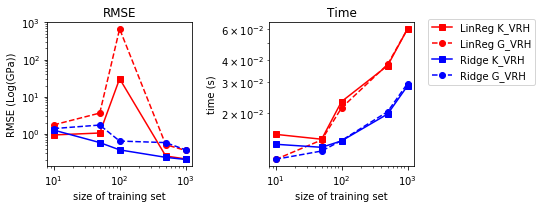

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('RMSE')
ax2.set_title('Time')

ax1.set_xlabel('size of training set')
ax1.set_ylabel('RMSE (Log(GPa))')
ax1.loglog(sizes, lr_stats['K']['rmse'], 'r', marker='s', label='LinReg K_VRH')
ax1.loglog(sizes, lr_stats['G']['rmse'], 'r--', marker='o', label='LinReg G_VRH')
ax1.loglog(sizes, ridge_stats['K']['rmse'], 'b', marker='s', label='Ridge K_VRH')
ax1.loglog(sizes, ridge_stats['G']['rmse'], 'b--', marker='o', label='Ridge G_VRH')

ax2.set_xlabel('size of training set')
ax2.set_ylabel('time (s)')
ax2.loglog(sizes, lr_stats['K']['time'], 'r', marker='s')
ax2.loglog(sizes, lr_stats['G']['time'], 'r--', marker='o')
ax2.loglog(sizes, ridge_stats['K']['time'], 'b', marker='s')
ax2.loglog(sizes, ridge_stats['G']['time'], 'b--', marker='o')

fig.legend(bbox_to_anchor=(1.25, 0.9))
fig.set_size_inches((6, 3))
fig.tight_layout()
plt.show()

#### 3) Ensemble method: RandomForestRegressor 

100 estimators are used

In [11]:
num_trees = 100

In [12]:
rfr_stats = {'K': {'mae': [0.0 for i in sizes], 'rmse': [0.0 for i in sizes], 
                  'r2': [0.0 for i in sizes], 'time': [0.0 for i in sizes]}, 
            'G': {'mae': [0.0 for i in sizes], 'rmse': [0.0 for i in sizes], 
                  'r2': [0.0 for i in sizes], 'time': [0.0 for i in sizes]}}

In [13]:
for ft in ['K', 'G']:
    for i, size in enumerate(sizes):
        start = time.perf_counter()
        for train_index, test_index in ShuffleSplit(n_splits=num_splits, test_size=100, train_size=size).split(x):
            model = RandomForestRegressor(n_estimators=num_trees)
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[ft][train_index], y[ft][test_index]
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)

            rfr_stats[ft]['mae'][i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
            rfr_stats[ft]['rmse'][i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))/num_splits
            rfr_stats[ft]['r2'][i] += r2_score(y_test, y_pred) / num_splits

        finish = time.perf_counter()
        rfr_stats[ft]['time'][i] = finish - start

#### 4) Ensemble method: ExtraTreesRegressor

In [14]:
efr_stats = {'K': {'mae': [0.0 for i in sizes], 'rmse': [0.0 for i in sizes], 
                  'r2': [0.0 for i in sizes], 'time': [0.0 for i in sizes]}, 
            'G': {'mae': [0.0 for i in sizes], 'rmse': [0.0 for i in sizes], 
                  'r2': [0.0 for i in sizes], 'time': [0.0 for i in sizes]}}

In [15]:
for ft in ['K', 'G']:
    for i, size in enumerate(sizes):
        start = time.perf_counter()
        for train_index, test_index in ShuffleSplit(n_splits=num_splits, test_size=100, train_size=size).split(x):
            model = ExtraTreesRegressor(n_estimators=num_trees)
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[ft][train_index], y[ft][test_index]
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)

            efr_stats[ft]['mae'][i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
            efr_stats[ft]['rmse'][i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))/num_splits
            efr_stats[ft]['r2'][i] += r2_score(y_test, y_pred) / num_splits

        finish = time.perf_counter()
        efr_stats[ft]['time'][i] = finish - start

#### 5) Ensemble method: GradientBoosting 

In [16]:
gbr_stats = {'K': {'mae': [0.0 for i in sizes], 'rmse': [0.0 for i in sizes], 
                  'r2': [0.0 for i in sizes], 'time': [0.0 for i in sizes]}, 
            'G': {'mae': [0.0 for i in sizes], 'rmse': [0.0 for i in sizes], 
                  'r2': [0.0 for i in sizes], 'time': [0.0 for i in sizes]}}

In [17]:
for ft in ['K', 'G']:
    for i, size in enumerate(sizes):
        start = time.perf_counter()
        for train_index, test_index in ShuffleSplit(n_splits=num_splits, test_size=100, train_size=size).split(x):
            model = GradientBoostingRegressor(n_estimators=num_trees, max_depth=3)
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[ft][train_index], y[ft][test_index]
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)

            gbr_stats[ft]['mae'][i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
            gbr_stats[ft]['rmse'][i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))/num_splits
            gbr_stats[ft]['r2'][i] += r2_score(y_test, y_pred) / num_splits

        finish = time.perf_counter()
        gbr_stats[ft]['time'][i] = finish - start

#### Quantifying trade off of time performance and accuracy of model with respect to size of data 

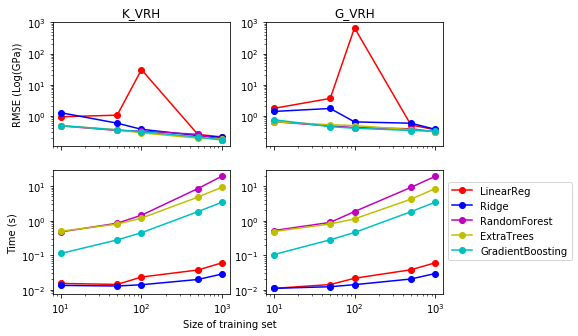

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, sharex=True)

ax[0,0].set_title('K_VRH')
ax[0,1].set_title('G_VRH')
ax[0,0].set_ylabel('RMSE (Log(GPa))')
ax[1,0].set_ylabel('Time (s)')
ax[1,0].set_xlabel('Size of training set', x=1, y=1)
ax[0,0].get_shared_y_axes().join(ax[0,0], ax[0,1])
ax[1,0].get_shared_y_axes().join(ax[1,0], ax[1,1])

for i in range(2):
    for j in range(2):
        ft = 'K' if j==0 else 'G'
        stat = 'rmse' if i==0 else 'time'
        ax[i,j].loglog(sizes, lr_stats[ft][stat], color='r', marker='o', label='LinearReg')
        ax[i,j].loglog(sizes, ridge_stats[ft][stat], color='b', marker='o', label='Ridge')
        ax[i,j].loglog(sizes, rfr_stats[ft][stat], color='m', marker='o', label='RandomForest')
        ax[i,j].loglog(sizes, efr_stats[ft][stat], color='y', marker='o', label='ExtraTrees')
        ax[i,j].loglog(sizes, gbr_stats[ft][stat], color='c', marker='o', label='GradientBoosting')

ax[1,1].legend(bbox_to_anchor=(1., 0.95))

fig.set_size_inches(7, 5)
fig.subplots_adjust(wspace=0.2)
plt.show()

*Finding*: GradientBoosting ensemble algorithm yields lowest prediction error (but has to have larger dataset) and has relatively good time performance. Linear Regression performs the worst.

Also, MAE of K is a few orders of magnitude larger than in De Jong's paper. MAE of G is ten times larger.